# Assignment 2: Morphological Edge detection with SSD template matching

## Finding Disparity Map

In [1]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
dmin = 260
dmax = 190
focal_length = 3740
baseline = 160

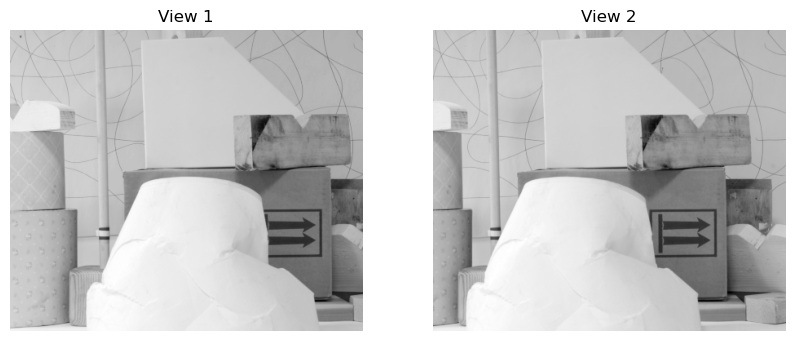

In [3]:
img1 = io.imread('Lampshade1/view1.png', as_gray=True)
img2 = io.imread('Lampshade1/view5.png', as_gray=True)

gt_disp = io.imread('Lampshade1/disp1.png', as_gray=True)

# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('View 1')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title('View 2')
plt.axis('off')
plt.show()

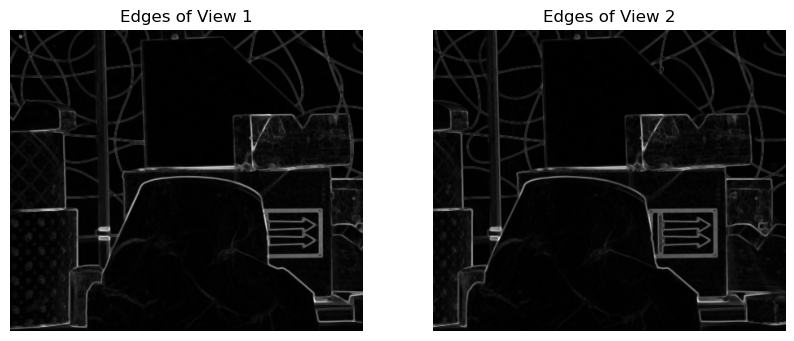

In [4]:
# find edges using morphological operations
from skimage.filters import sobel
from skimage.morphology import dilation, erosion, disk
edges1 = sobel(img1)
edges2 = sobel(img2)

edges1 = dilation(edges1, disk(1))
edges2 = dilation(edges2, disk(1))

edges1 = erosion(edges1, disk(1))
edges2 = erosion(edges2, disk(1))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges1, cmap='gray')
plt.title('Edges of View 1')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(edges2, cmap='gray')
plt.title('Edges of View 2')
plt.axis('off')
plt.show()

100%|██████████| 356/356 [02:39<00:00,  2.23it/s]


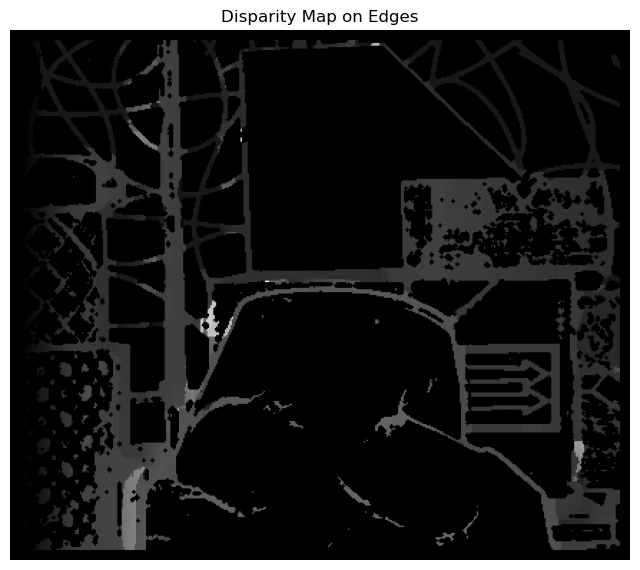

In [5]:
disparity_map_edges = np.zeros(img1.shape)
ssds = []
window_size = 15

for i in tqdm(range(window_size//2, img1.shape[0] - window_size//2)):
    # for first image
    for j in range(window_size//2, img1.shape[1] - window_size//2):
        if edges1[i, j] > edges1.mean():
            window1 = img1[i - window_size//2:i + window_size//2 + 1, j - window_size//2:j + window_size//2 + 1]
            ssd_min = np.inf
            disparity = 0
            # for second image
            for k in range(window_size//2, j+1):
                window2 = img2[i - window_size//2:i + window_size//2 + 1, k - window_size//2:k + window_size//2 + 1]
                ssd = np.sum((window1 - window2) ** 2)
                if ssd < ssd_min:
                    ssd_min = ssd
                    ssds.append(ssd)
                    # sum of squared of values of window1
                    ssv1 = np.sum(window1 ** 2)
                    rel_ssd = ssd / ssv1
                    disparity = np.abs(j - k) if rel_ssd < 0.05 else 0
            disparity_map_edges[i, j] = disparity
            
disparity_map_edges[disparity_map_edges > dmax] = 0
plt.figure(figsize=(8, 8))
plt.imshow(disparity_map_edges, cmap='gray')
plt.title('Disparity Map on Edges')
plt.axis('off')
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:29<00:00, 167.14it/s]


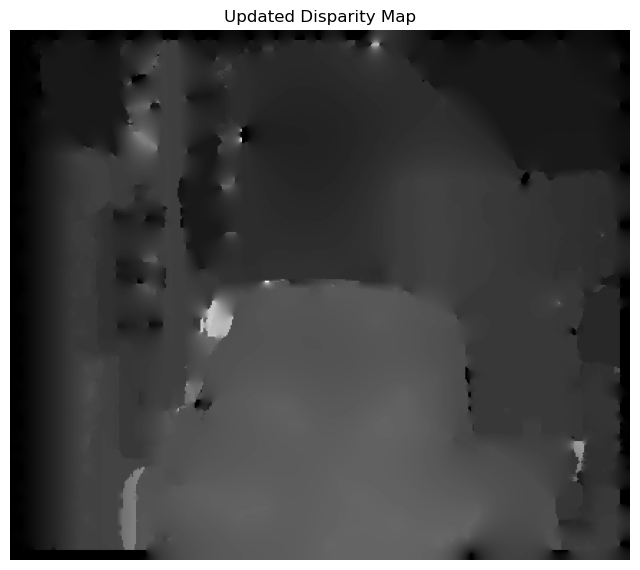

In [6]:
from scipy.ndimage import uniform_filter

# Initialize the disparity map with the edges disparity values
updated_disparity_map = disparity_map_edges.copy()

# Number of iterations
num_iterations = 5000

for _ in tqdm(range(num_iterations)):
    # Use scipy's uniform_filter to update the disparity map on non-edge regions

    # Apply mean filter
    updated_disparity_map = uniform_filter(updated_disparity_map, size=3)

    # Reinstate the values at the edges to original ones
    updated_disparity_map[edges1 > edges1.mean()] = disparity_map_edges[edges1 > edges1.mean()]

# Plot the updated disparity map
plt.figure(figsize=(8, 8))
plt.imshow(updated_disparity_map, cmap='gray')
plt.title('Updated Disparity Map')
plt.axis('off')
plt.show()

## Error Metrics

In [23]:
# map to 0 to 1
updated_disparity_map = (updated_disparity_map - dmin) / (dmax - dmin)
gt_disp = (gt_disp - dmin) / (dmax - dmin)

In [26]:
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(disp1, disp2):
    mse_value = np.mean((disp1 - disp2) ** 2)
    rmse_value = np.sqrt(mse_value)

    # Compute SSIM
    ssim_value, _ = ssim(disp1, disp2, data_range=max(gt_disp.max(), disp1.max()) - min(gt_disp.min(), disp1.min()), full=True)

    return mse_value, rmse_value, ssim_value

In [28]:
mse, rmse, ssim_value = calculate_metrics(gt_disp, updated_disparity_map)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'SSIM: {ssim_value}')

MSE: 1.3400150580424421
RMSE: 1.1575901943444589
SSIM: 0.711234836709783
